In [1]:
using PyPlot, Revise, Random, ProgressMeter
includet("2NNlogistic-param-predict.jl")
using3D()

In [2]:
"""
Train 2-layer relu NN with GD on square loss
INPUT
 m is the number of neurons, 
 alpha1 (resp. alpha2): scale of the initialization of the input (resp. output) weights
 ouly_output: train just the output layer (instead of both)
 sym_init: trick to make the output = 0 exactly at initialization
OUTPUT
 Ws: the whole training path
 loss: evolution of loss during training
"""
function twonet_square(X, Y, m, stepsize, niter;alpha1=1.0, alpha2=1.0, weight_decay=0.0, sym_init=false, only_output = false)
    (n,d) = size(X) # n samples in R^d
    # initialize
    W = randn(m, d+1)
    # input weights initialized uniformly on the unit sphere
    W[:,1:d] = W[:,1:d] .* alpha1 ./ sqrt.(sum(W[:,1:d].^2, dims=2))
    # output weights initialized by -1 or 1 with equal proba
    W[1:div(m,2),end] .= alpha2
    W[div(m,2)+1:end,end] .= -alpha2
    W = W
    if sym_init
        @assert iseven(m)
        W[div(m,2)+1:end,1:d]  .=  W[1:div(m,2),1:d]
    end
    Ws    = zeros(m, d+1, niter) # store optimization path
    loss  = zeros(niter) # loss is -log of the empirical risk

    @showprogress 1 "Training neural network..." for iter = 1:niter
        Ws[:,:,iter] = W
        act  =  max.( W[:,1:end-1] * X', 0.0) # activations
        out  =  (1/m) * sum( W[:,end] .* act , dims=1)[:] # predictions of the network
        gradR   = (out .- Y)/n  # size n
        grad_w1 = (W[:,end] .* float.(act .> 0) * ( X .* gradR  )) + weight_decay * W[:,1:end-1] # gradient for input weights
        grad_w2 = act * gradR + weight_decay * W[:,end]  # gradient for output weights
        if only_output 
            grad = cat(zeros(m,d), grad_w2, dims=2) # size (m × d+1)
        else
            grad = cat(grad_w1, grad_w2, dims=2) # size (m × d+1)
        end
        loss[iter] = (1/2)*sum( ( out - Y).^2 )/n + (weight_decay/2)*sum(W.^2)/m
        W = W - stepsize * grad
    end

    return Ws, loss
end

twonet_square

In [80]:
X = [-1 1; -1/16 1; 1/16 1; 1 1]
Y = [-1; 1/2; -1/2; 1]
alpha1 = 50
alpha2s=[0 5 10 50]
m = 5000
WW = zeros(m,3,length(alpha2s))
for k = 1:length(alpha2s)
    alpha2 = alpha2s[k]
    stepsize = 0.003/(1+alpha2/20)
    niter = 10000
    Ws, loss = twonet_square(X, Y, m, stepsize, niter, alpha1=alpha1, alpha2=alpha2, sym_init=true)
    WW[:,:,k] .= Ws[:,:,end]
end
#loglog(loss)

Training neural network...100%|█████████████████████████| Time: 0:00:12
Training neural network...100%|█████████████████████████| Time: 0:00:11
Training neural network...100%|█████████████████████████| Time: 0:00:11
Training neural network...100%|█████████████████████████| Time: 0:00:11


In [ ]:
κ

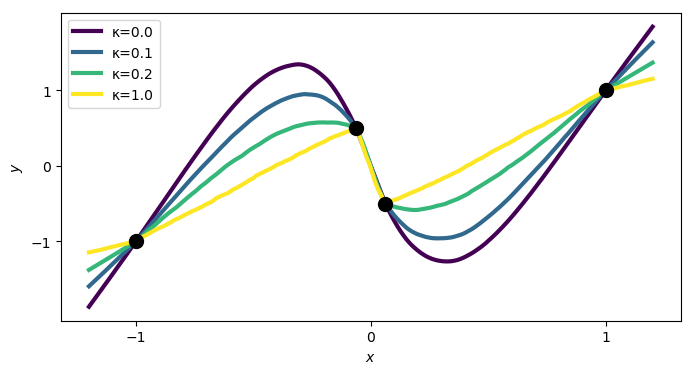

In [82]:
cm = plt.get_cmap("viridis")
figure(figsize=[8,4])
for k = 1:length(alpha2s)
X_test = cat(range(-1.2,1.2,length=200),ones(200),dims=2 )
    Y_test = (1/m) * sum( WW[:,end,k] .* max.( WW[:,1:end-1,k] * X_test', 0.0) , dims=1)[:]
plot(X_test[:,1], Y_test, color=cm((k-1)/(length(alpha2s)-1)),label="κ=$(alpha2s[k]/50)",lw=3)
end
legend()
plot(X[:,1],Y,"ko",ms=10)
xticks([-1,0,1]);xlabel(L"x")
yticks([-1,0,1]);ylabel(L"y")
#savefig("interp.png",dpi=100)

# Weight decay

In [9]:
X = [-1 1; -1/16 1; 1/16 1; 1 1]
Y = [-1; 1/2; -1/2; 1]
m = 1000
WW = zeros(m,3,length(alpha2s))
for k = 1:length(alpha2s)
    alpha2 = alpha2s[k]
    stepsize = 0.2
    niter = 10000
    Ws, loss = twonet_square(X, Y, m, stepsize, niter, weight_decay=0.0005, only_output =false)
    WW[:,:,k] .= Ws[:,:,end]
end
cm = plt.get_cmap("viridis")
figure(figsize=[8,4])
for k = 1:length(alpha2s)
X_test = cat(range(-1.2,1.2,length=200),ones(200),dims=2 )
    Y_test = (1/m) * sum( WW[:,end,k] .* max.( WW[:,1:end-1,k] * X_test', 0.0) , dims=1)[:]
plot(X_test[:,1], Y_test, color=cm((k-1)/(length(alphas)-1)),label="r=$(alpha2s[k]/50)",lw=3)
end
legend()
plot(X[:,1],Y,"ko",ms=10)
xticks([-1,0,1]);xlabel(L"x")
#yticks([-1,0,1]);ylabel(L"y")
#savefig("interp.png",dpi=100)

Training neural network...100%|█████████████████████████| Time: 0:00:02
Training neural network...100%|█████████████████████████| Time: 0:00:02
Training neural network...100%|█████████████████████████| Time: 0:00:01
Training neural network...100%|█████████████████████████| Time: 0:00:02


UndefVarError: UndefVarError: alphas not defined

Training neural network...100%|█████████████████████████| Time: 0:00:06
Training neural network...100%|█████████████████████████| Time: 0:00:13


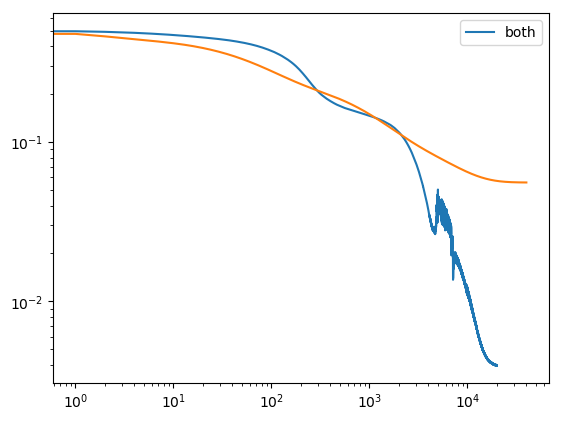

PyObject <matplotlib.legend.Legend object at 0x7fee10f92e10>

In [84]:
Random.seed!(5)
d=3
n = 10
m = 1000
X = cat(2*(rand(n,2).-0.5), ones(n), dims=2)
Y = rand([-1,1],n)
stepsize = 0.1
niter = 20000
Ws, loss = twonet_square(X, Y, m, stepsize, niter, weight_decay=0.00005, only_output =false)
loglog(loss,label="both")
stepsize = 8
niter = 40000
Ws2, loss2 = twonet_square(X, Y, m, stepsize, niter, weight_decay=0.000005, only_output =true)
loglog(loss2)
legend()

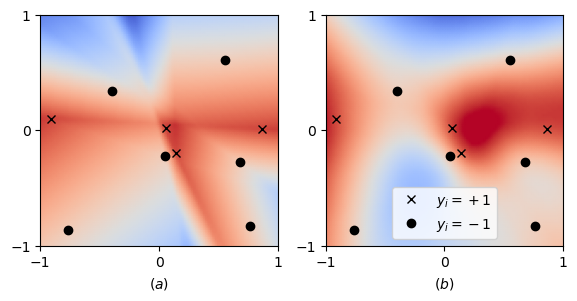

┌ Warning: /Users/chizat/Documents/code/2020_blogpost_implicitbias/2NNlogistic-param-predict.jl no longer exists, deleting all methods
└ @ Revise /Users/chizat/.julia/packages/Revise/AMRie/src/Revise.jl:555


In [110]:
colm = "coolwarm"#"magma"
cm = plt.get_cmap(colm)
#figure(figsize=[8,4])
f(x1,x2) = (1/m) * sum( Ws[:,end,end] .* max.( Ws[:,1:3,end] * [x1;x2;1], 0.0)) # prediction function
f2(x1,x2) = (1/m) * sum( Ws2[:,end,end] .* max.( Ws2[:,1:3,end] * [x1;x2;1], 0.0)) # prediction function
    reso = 100 
    xs = range(-1.0,1.0,length=reso)
    tab = [f(xs[i],xs[j]) for i=1:length(xs), j=1:length(xs)]
    tab2 = [f2(xs[i],xs[j]) for i=1:length(xs), j=1:length(xs)]

figure(figsize=[6.75,3])
subplot(121)
#title("Training both layers")
    pcolormesh(xs', xs, tab', cmap=colm, shading="gouraud",vmin=-4.5,vmax = 1.5,edgecolor="face")
    cm = plt.get_cmap("coolwarm")
#scatter(X[:,1],X[:,2],50,c=cm.(2*(Y .- 0.5)),edgecolors="w")
plot(X[Y.==1,1],X[Y.==1,2],"xk")
plot(X[Y.==-1,1],X[Y.==-1,2],"ok")
xticks([-1,0,1]);xlabel(L"(a)")
yticks([-1,0,1])#;ylabel(L"y")

subplot(122)
 ax =   pcolormesh(xs', xs, tab2', cmap=colm, shading="gouraud",vmin=-4.5,vmax = 1.5,edgecolor="face")
    cm = plt.get_cmap(colm)
#scatter(X[:,1],X[:,2],50,c=cm.(Y/6 .+0.7),edgecolors="k",label=L"y_i=+1")
#scatter(X[Y.==-1,1],X[Y.==-1,2],50,c=cm.(-1/6 .+0.7),edgecolors="k",label=L"y_i=-1")
plot(X[Y.==1,1],X[Y.==1,2],"xk",label=L"y_i=+1")
plot(X[Y.==-1,1],X[Y.==-1,2],"ok",label=L"y_i=-1")
legend(loc=8)
#title("Training output layer")
xticks([-1,0,1]);xlabel(L"(b)")
yticks([-1,0,1])#;ylabel(L"y"
#savefig("regularized.png",dpi=150,bbox_inches="tight")
#subplot(133)
#figure(figsize=[4,3])
#imshow(cat(R,G,B,dims=3),origin="lower",aspect=.2);#axis("off")
#yticks([1,401],[-4.5,1.5])
#xticks(1:0,[])

In [69]:
hh,ll = 400, 10
pp = repeat(0:(1/hh):1,1,ll)
vec = cm.(0:(1/hh):1)
R = [vec[i][1] for i=1:hh, j=1:ll]
G = [vec[i][2] for i=1:hh, j=1:ll]
B = [vec[i][3] for i=1:hh, j=1:ll];

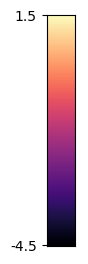

In [73]:
figure(figsize=[4,3])
imshow(cat(R,G,B,dims=3),origin="lower",aspect=.2);#axis("off")
yticks([1,401],[-4.5,1.5])
xticks(1:0,[])
#savefig("bluecolorbar.png",transparent=true, bbox_inches="tight");

In [45]:

#norm = mpl.colors.Normalize(vmin=5, vmax=10)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
fig = figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
colorbar.ColorbarBase(ax1, cmap=cm)

ErrorException: type #colorbar has no field ColorbarBase

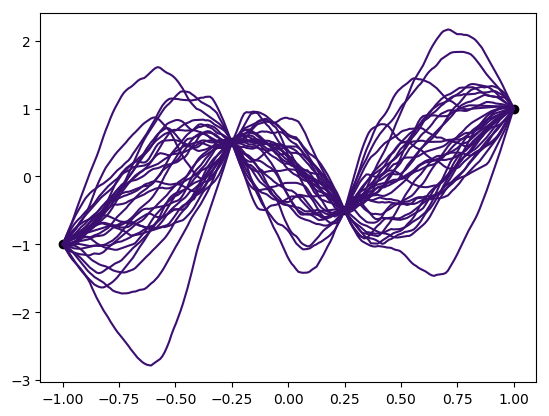

In [278]:
X = [-1 1; -1/4 1; 1/4 1; 1 1]
Y = [-1; 1/2; -1/2; 1]
alpha1 = 20
alpha2s=20
cm = plt.get_cmap("magma")
plot(X[:,1],Y,"ko")
for k = 1:length(alpha2s)
    for kk=1:30
    m = 300
    alpha2 = alpha2s[k]
    stepsize =0.03/alpha1
    niter = 1000
    Ws, loss = twonet_square(X, Y, m, stepsize, niter, alpha1, alpha2, sym_init=false)
    W = Ws[:,:,end]
    X_test = cat(range(-1,1,length=200),ones(200),dims=2 )
    Y_test = (1/m) * sum( W[:,end] .* max.( W[:,1:end-1] * X_test', 0.0) , dims=1)[:]
    plot(X_test[:,1], Y_test, color=cm((k)/(length(alphas)+1)))
    end
end
#loglog(loss)

In [65]:
Y_test

10-element Array{Float64,1}:
 -0.9922647172988863
 -0.5606705951323989
 -0.12907647296591138
  0.30251764920057617
  0.20634208680784147
 -0.20635066209056513
 -0.3025345705207978
  0.12906212892541474
  0.5606588283716273
  0.9922555278178399

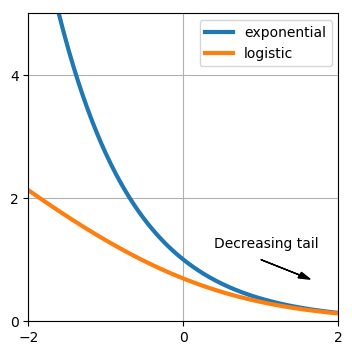

In [552]:
xs = -2:0.01:2
figure(figsize=[4,4])
plot(xs, exp.(-xs),label="exponential",lw=3)
plot(xs, log.(1 .+ exp.(-xs)),label="logistic",lw=3)
arrow(1,1,0.5,-0.25,head_width=0.1,color="k")
text(0.4,1.2,"Decreasing tail")
legend()
xticks([-2; 0; 2])
yticks([ 0; 2; 4; 6])
axis([-2,2, 0,5])
grid("on")
#savefig("logistic_exp.png",dpi=150,bbox_inches="tight")

## 